## Setup

Import pakietów

In [ ]:
from keras.callbacks import History
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.datasets import cifar10
from keras.engine import training
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Activation, Average
from keras.losses import categorical_crossentropy
from keras.models import Model, Input
from keras.optimizers import Adam
from tensorflow.python.framework.ops import Tensor
from typing import Tuple, List
import glob
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, Input, MaxPool2D, add, Flatten, Dense, DepthwiseConv2D
import cv2
import matplotlib.pyplot as plt
import os, datetime

Ładowanie wspólnej warstwy inputu dla modeli

In [ ]:
x = np.load('/content/drive/MyDrive/data/x_test_all.npy')
input_shape = x[0,:,:,:].shape
model_input = Input(shape=input_shape)

Nowy model do ensemble'a

In [ ]:
def conv_pool_cnn(model_input: Tensor) -> training.Model:
    
    x = Conv2D(96, kernel_size=(3, 3), activation='relu', padding = 'same')(model_input)
    x = Conv2D(96, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(96, (3, 3), activation='relu', padding = 'same')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides = 2)(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides = 2)(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (1, 1), activation='relu')(x)
    x = Conv2D(3, (1, 1))(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation(activation='softmax')(x)
    
    model = Model(model_input, x, name='conv_pool_cnn')
    
    return model

COVIDNet

In [ ]:
def PEPXModel(input_tensor, filters, name):
    x = Conv2D(filters=filters, kernel_size=(1, 1), activation='relu', name=name + 'FP')(input_tensor)
    x = Conv2D(filters=filters, kernel_size=(1, 1), activation='relu', name=name + 'Expansion')(x)
    x = DepthwiseConv2D(kernel_size=(3, 3), activation='relu', padding='same', name=name + 'DWConv3_3')(x)
    x = Conv2D(filters=filters, kernel_size=(1, 1), activation='relu', name=name + 'SP')(x)
    x = Conv2D(filters=filters, kernel_size=(1, 1), activation='relu', name=name + 'Extension')(x)
    return x


In [ ]:
def keras_model_build(model_input: Tensor):
    # 输


    #input = Input(shape=input_size, name='input')
    x = Conv2D(input_shape=input_shape, filters=64, kernel_size=(7, 7), activation='relu', padding='same',
               strides=(2, 2))(model_input)
    x = MaxPool2D(pool_size=(2, 2))(x)
    # PEPX1_Conv1x1
    p_1_y = Conv2D(256, (1, 1), padding='same', activation='relu', name='PEPX1_Conv')(x)

    # Stage1结构
    y_1_1 = PEPXModel(x, 256, 'PEPX1.1')
    y_1_2 = PEPXModel(add([y_1_1, p_1_y]), 256, 'PEPX1.2')
    y_1_3 = PEPXModel(add([y_1_1, y_1_2, p_1_y]), 256, 'PEPX1.3')
    # PEPX2_Conv1x1
    p_2_y = Conv2D(512, (1, 1), padding='same', activation='relu', name='PEPX2_Conv')(add([p_1_y, y_1_1, y_1_2, y_1_3]))
    p_2_y = MaxPool2D(pool_size=(2, 2))(p_2_y)
    # Stage2结构
    y_2_1 = PEPXModel(add([y_1_3, y_1_2, y_1_1, p_1_y]), 512, 'PEPX2.1')
    y_2_1 = MaxPool2D(pool_size=(2, 2))(y_2_1)
    y_2_2 = PEPXModel(add([y_2_1, p_2_y]), 512, 'PEPX2.2')
    y_2_3 = PEPXModel(add([y_2_1, y_2_2, p_2_y]), 512, 'PEPX2.3')
    y_2_4 = PEPXModel(add([y_2_1, y_2_2, y_2_3, p_2_y]), 512, 'PEPX2.4')
    # PEPX3_Conv1x1
    p_3_y = Conv2D(1024, (1, 1), padding='same', activation='relu', name='PEPX3_Conv')(
        add([p_2_y, y_2_1, y_2_2, y_2_3, y_2_4])
    )
    p_3_y = MaxPool2D(pool_size=(2, 2))(p_3_y)
    # Stage3结构
    y_3_1 = PEPXModel(add([y_2_1, y_2_2, y_2_3, y_2_4, p_2_y]), 1024, 'PEPX3.1')
    y_3_1 = MaxPool2D(pool_size=(2, 2))(y_3_1)
    y_3_2 = PEPXModel(y_3_1, 1024, 'PEPX3.2')
    y_3_3 = PEPXModel(add([y_3_1, y_3_2]), 1024, 'PEPX3.3')
    y_3_4 = PEPXModel(add([y_3_1, y_3_2, y_3_3]), 1024, 'PEPX3.4')
    y_3_5 = PEPXModel(add([y_3_1, y_3_2, y_3_3, y_3_4]), 1024, 'PEPX3.5')
    y_3_6 = PEPXModel(add([y_3_1, y_3_2, y_3_3, y_3_4, y_3_5]), 1024, 'PEPX3.6')
    # PEPX4_Conv1x1
    p_4_y = Conv2D(2048, (1, 1), padding='same', activation='relu', name='PEPX4_Conv1')(
        add([p_3_y, y_3_1, y_3_2, y_3_3, y_3_4, y_3_5, y_3_6])
    )
    p_4_y = MaxPool2D(pool_size=(2, 2))(p_4_y)
    # Stage4结构
    y_4_1 = PEPXModel(add([y_3_1, y_3_2, y_3_3, y_3_4, y_3_5, y_3_6, p_3_y]), 2048, 'PEPX4.1')
    y_4_1 = MaxPool2D(pool_size=(2, 2))(y_4_1)
    y_4_2 = PEPXModel(add([y_4_1, p_4_y]), 2048, 'PEPX4.2')
    y_4_3 = PEPXModel(add([y_4_1, y_4_2, p_4_y]), 2048, 'PEPX4.3')
    # FC
    fla = Flatten()(add([y_4_1, y_4_2, y_4_3, p_4_y]))
    d1 = Dense(1024, activation='relu')(fla)
    d2 = Dense(256, activation='relu')(d1)
    output = Dense(3, activation='softmax')(d2)

    return keras.models.Model(model_input, output)

## Kod trenowania

In [ ]:
def confusion_matrix_info(y_true, y_pred, labels=['normal', 'pneumonia', 'COVID-19'],
                          title='confusion matrix'):
    import seaborn as sns
    import pandas as pd
    from sklearn.metrics import confusion_matrix, f1_score
    import matplotlib.pyplot as plt
    C2 = confusion_matrix(y_true, y_pred)
    C = pd.DataFrame(C2, columns=labels, index=labels)
    m, _ = C2.shape
    for i in range(m):
        precision = C2[i, i] / sum(C2[:, i])
        recall = C2[i, i] / sum(C2[i, :])
        f1 = 2 * precision * recall / (precision + recall)
        print('In class {}:\t total samples: {}\t true predict samples: {}\t'
              'acc={:.4f},\trecall={:.4f},\tf1-score={:.4f}'.format(
            labels[i], sum(C2[i, :]), C2[i, i], precision, recall, f1))
    print('-' * 100, '\n', 'average f1={:.4f}'.format(f1_score(y_true, y_pred, average='micro')))

    f, ax = plt.subplots()
    sns.heatmap(C, annot=True, ax=ax, cmap=plt.cm.binary)
    ax.set_title(title)
    ax.set_xlabel('predict')
    ax.set_ylabel('true')
    plt.savefig(title+'.jpg')

In [ ]:
def train_covid():
    x = np.load('/content/drive/MyDrive/data/x_test_all.npy')
    y = np.load('/content/drive/MyDrive/data/y_test_all.npy')
    y = tf.keras.utils.to_categorical(y, 3)
    model = keras_model_build(model_input)
    # model.summary()
    opt=tf.keras.optimizers.Adam(lr=0.00001)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    hist = model.fit(x, y, batch_size=32, epochs=1, verbose=1, callbacks=[])
    #model.save('model.h5')
    y_pred = model.predict(x)
    confusion_matrix_info(np.argmax(y, axis=1), np.argmax(y_pred, axis=1),title='confusion_matrix_train')
    return model

In [ ]:
def train_conv():
    x = np.load('/content/drive/MyDrive/data/x_test_all.npy')
    y = np.load('/content/drive/MyDrive/data/y_test_all.npy')
    y = tf.keras.utils.to_categorical(y, 3)
    model = conv_pool_cnn(model_input)
    # model.summary()
    opt=tf.keras.optimizers.Adam()
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    hist = model.fit(x, y, batch_size=32, epochs=1, verbose=1, callbacks=[])
    #model.save('model.h5')
    y_pred = model.predict(x)
    confusion_matrix_info(np.argmax(y, axis=1), np.argmax(y_pred, axis=1),title='confusion_matrix_train')
    return model

Ensemble modeli

In [ ]:
def ensemble(models: List [training.Model], model_input: Tensor) -> training.Model:
    
    outputs = [model.outputs[0] for model in models]
    y = Average()(outputs)
    
    model = Model(model_input, y, name='ensemble')
    
    return model

## Łączenie modeli

In [ ]:
x = np.load('/content/drive/MyDrive/data/x_train.npy')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


50/50 [==============================] - 4680s 93s/step - loss: 0.8945 - accuracy: 0.5541
In class normal:	 total samples: 885	 true predict samples: 885	acc=0.5605,	recall=1.0000,	f1-score=0.7183
In class pneumonia:	 total samples: 594	 true predict samples: 0	acc=nan,	recall=0.0000,	f1-score=nan
In class COVID-19:	 total samples: 100	 true predict samples: 0	acc=nan,	recall=0.0000,	f1-score=nan
---------------------------------------------------------------------------------------------------- 
 average f1=0.5605


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


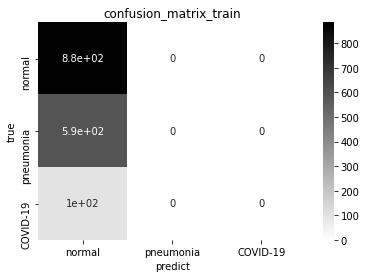

In [ ]:
covid = train_covid()

In [ ]:
conv = train_conv()

In [ ]:
models = [covid, conv]

In [ ]:
ens = ensemble(models, model_input)

In [ ]:
conv.predict(x)

array([[0.29702783, 0.33043447, 0.37253773],
       [0.27553248, 0.32712114, 0.3973464 ],
       [0.27561378, 0.32707995, 0.39730623],
       [0.27817792, 0.32757708, 0.394245  ],
       [0.27302778, 0.32663107, 0.4003411 ],
       [0.27482173, 0.32701728, 0.398161  ],
       [0.29522827, 0.3301379 , 0.37463385],
       [0.2923026 , 0.32979584, 0.37790155],
       [0.27797496, 0.32745084, 0.3945742 ]], dtype=float32)

In [ ]:
covid.predict(x)

array([[0.32386994, 0.33792108, 0.33820894],
       [0.32200593, 0.33773634, 0.34025773],
       [0.32162428, 0.33801302, 0.3403627 ],
       [0.32031026, 0.33689687, 0.34279284],
       [0.32050914, 0.3357319 , 0.343759  ],
       [0.32059076, 0.3378283 , 0.3415809 ],
       [0.32566413, 0.33648002, 0.3378559 ],
       [0.32631573, 0.3365589 , 0.33712542],
       [0.32361934, 0.33670452, 0.33967608]], dtype=float32)

In [ ]:
ens.predict(x)

array([[0.31044888, 0.3341778 , 0.35537332],
       [0.2987692 , 0.33242875, 0.36880207],
       [0.29861903, 0.33254647, 0.36883447],
       [0.2992441 , 0.33223698, 0.36851892],
       [0.29676843, 0.33118147, 0.37205005],
       [0.29770625, 0.3324228 , 0.36987096],
       [0.3104462 , 0.33330894, 0.35624486],
       [0.30930918, 0.3331774 , 0.3575135 ],
       [0.30079716, 0.33207768, 0.36712515]], dtype=float32)

Wszystko śmiga